## Import all libraries


In [1]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import SMOTEN
import pycaret.classification as pc
import pandas as pd
import os
import sys

# set the working directory
sys.path.append(os.getcwd() + os.sep + ".." + os.sep + "..")


# import from ../script/data.py in scripts folder
from src.scripts.mapping_answers_dict import *

define some functions


In [2]:
def read_dataframes(folder_path):
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dataframes = {file: pd.read_csv(os.path.join(
        folder_path, file)) for file in file_list}
    return dataframes


def get_common_columns(dataframes):
    common_columns = dataframes[list(dataframes.keys())[0]].columns
    for df in dataframes.values():
        common_columns = common_columns.intersection(df.columns)
    return common_columns


def preprocess_dataframes(dataframes, common_columns):
    merged_df = pd.DataFrame()
    for i, (file, df) in enumerate(dataframes.items()):
        df = df[common_columns]
        df.insert(0, "State", file.split(" ")[2])
        # df.insert(0, "State", i)
        merged_df = pd.concat([merged_df, df])
    return merged_df

Import and preprocess data


In [3]:

# Read dataframes from GYTS folder
dataframes = read_dataframes("../../data/raw/GYTS/")

# Find common columns in all dataframes
common_columns = get_common_columns(dataframes)
print(common_columns)

# Preprocess dataframes
merged_df = preprocess_dataframes(dataframes, common_columns)


# Rename columns
merged_df.rename(columns={"CR1": "Age"}, inplace=True)
merged_df["Age"] = merged_df["Age"].map(CR1_dict)

merged_df.rename(columns={"CR2": "Gender"}, inplace=True)
merged_df["Gender"] = merged_df["Gender"].map(CR2_dict)

merged_df["CR8"] = merged_df["CR8"].map(CR8_smoke_dict)
merged_df.rename(columns={"CR8": "Smoke"}, inplace=True)

merged_df.rename(columns={"OR45": "SmokingParents"}, inplace=True)
merged_df.rename(columns={"OR46": "SmokingFriends"}, inplace=True)
merged_df["SmokingFriends"] = merged_df["SmokingFriends"].map(OR46_dict)
merged_df.rename(columns={"OR1": "WorkingParents"}, inplace=True)
merged_df["WorkingParents"] = merged_df["WorkingParents"].map(OR1_dict)
merged_df.rename(columns={"CR22": "SeenSmokerInSchool"}, inplace=True)
merged_df["SeenSmokerInSchool"] = merged_df["SeenSmokerInSchool"].map(
    CR22_dict)
merged_df.rename(columns={"CR21": "SeenSmokerInPublicPlace"}, inplace=True)
merged_df["SeenSmokerInPublicPlace"] = merged_df["SeenSmokerInPublicPlace"].map(
    CR21_dict)
merged_df.rename(columns={"CR20": "SeenSmokerInEnclosedPlace"}, inplace=True)
merged_df["SeenSmokerInEnclosedPlace"] = merged_df["SeenSmokerInEnclosedPlace"].map(
    CR20_dict)
merged_df.rename(columns={"CR19": "SeenSmokerInHome"}, inplace=True)
merged_df["SeenSmokerInHome"] = merged_df["SeenSmokerInHome"].map(CR19_dict)

merged_df.rename(columns={"OR55": "ParentWarnings"}, inplace=True)
merged_df["ParentWarnings"] = merged_df["ParentWarnings"].map(OR55_dict)

merged_df.rename(columns={"OR49": "AttractiveSmoker"}, inplace=True)
merged_df["AttractiveSmoker"] = merged_df["AttractiveSmoker"].map(OR49_dict)

merged_df.rename(columns={"CR41": "HardQuitSmoke"}, inplace=True)
merged_df["HardQuitSmoke"] = merged_df["HardQuitSmoke"].map(CR41_dict)

merged_df.rename(
    columns={"CR42": "SmokerConfidentInCelebrations"}, inplace=True)
merged_df["SmokerConfidentInCelebrations"] = merged_df["SmokerConfidentInCelebrations"].map(
    CR42_dict)

merged_df.rename(columns={"CR33": "SchoolWarnings"}, inplace=True)
merged_df["SchoolWarnings"] = merged_df["SchoolWarnings"].map(CR33_dict)

merged_df.rename(columns={"CR32": "SeenHealthWarnings"}, inplace=True)
merged_df["SeenHealthWarnings"] = merged_df["SeenHealthWarnings"].map(
    CR32_dict)

merged_df.rename(columns={"CR31": "AntiTobaccoInEvents"}, inplace=True)
merged_df["AntiTobaccoInEvents"] = merged_df["AntiTobaccoInEvents"].map(
    CR31_dict)

merged_df.rename(columns={"CR30": "AntiTobaccoInMedia"}, inplace=True)
merged_df["AntiTobaccoInMedia"] = merged_df["AntiTobaccoInMedia"].map(
    CR30_dict)

merged_df.rename(columns={"CR25": "BanTobaccoOutdoors"}, inplace=True)
merged_df["BanTobaccoOutdoors"] = merged_df["BanTobaccoOutdoors"].map(
    CR25_dict)

merged_df.rename(columns={"CR23": "HarmfulPassiveSmoke"}, inplace=True)
merged_df["HarmfulPassiveSmoke"] = merged_df["HarmfulPassiveSmoke"].map(
    CR23_dict)

# Keep only the desired columns
merged_df = merged_df[["State", "Gender", "Age", "Smoke", "SmokingParents", "SmokingFriends", "WorkingParents",
                       "SeenSmokerInSchool", "SeenSmokerInPublicPlace", "SeenSmokerInEnclosedPlace",
                       "SeenSmokerInHome", "ParentWarnings", "AttractiveSmoker", "HardQuitSmoke",
                       "SmokerConfidentInCelebrations", "SchoolWarnings", "SeenHealthWarnings",
                       "AntiTobaccoInEvents", "AntiTobaccoInMedia", "BanTobaccoOutdoors",
                       "HarmfulPassiveSmoke"
                       ]]

# Drop rows with missing values
merged_df = merged_df.dropna()

merged_df['SmokingFather'] = merged_df['SmokingParents'].apply(
    lambda x: True if OR45_dict[x] in ['Both', 'Father only'] else False)
merged_df['SmokingMother'] = merged_df['SmokingParents'].apply(
    lambda x: True if OR45_dict[x] in ['Both', 'Mother only'] else False)
merged_df = merged_df.drop(columns=['SmokingParents'])

merged_df['WorkingFather'] = merged_df['WorkingParents'].apply(
    lambda x: True if x in ['Both', 'Father only'] else False)
merged_df['WorkingMother'] = merged_df['WorkingParents'].apply(
    lambda x: True if x in ['Both', 'Mother only'] else False)
merged_df = merged_df.drop(columns=['WorkingParents'])

# Convert columns to categorical
merged_df['State'] = merged_df['State'].astype('category')
merged_df["Gender"] = merged_df["Gender"].astype('category')
merged_df["Age"] = merged_df["Age"].astype('category')
merged_df["SmokingFriends"] = merged_df["SmokingFriends"].astype('category')
merged_df["SeenSmokerInPublicPlace"] = merged_df["SeenSmokerInPublicPlace"].astype(
    'category')
merged_df["SeenSmokerInEnclosedPlace"] = merged_df["SeenSmokerInEnclosedPlace"].astype(
    'category')
merged_df["SeenSmokerInHome"] = merged_df["SeenSmokerInHome"].astype(
    'category')
merged_df["AttractiveSmoker"] = merged_df["AttractiveSmoker"].astype(
    'category')
merged_df["HardQuitSmoke"] = merged_df["HardQuitSmoke"].astype('category')
merged_df["SmokerConfidentInCelebrations"] = merged_df["SmokerConfidentInCelebrations"].astype(
    'category')
merged_df["SchoolWarnings"] = merged_df["SchoolWarnings"].astype('category')
merged_df["SeenHealthWarnings"] = merged_df["SeenHealthWarnings"].astype(
    'category')
merged_df["AntiTobaccoInEvents"] = merged_df["AntiTobaccoInEvents"].astype(
    'category')
merged_df["HarmfulPassiveSmoke"] = merged_df["HarmfulPassiveSmoke"].astype(
    'category')

# Convert to boolean
merged_df["Smoke"] = merged_df["Smoke"].astype("bool")
merged_df["SeenSmokerInSchool"] = merged_df["SeenSmokerInSchool"].astype(
    'bool')
merged_df['SmokingFather'] = merged_df['SmokingFather'].astype('bool')
merged_df['SmokingMother'] = merged_df['SmokingMother'].astype('bool')
merged_df['WorkingFather'] = merged_df['WorkingFather'].astype('bool')
merged_df['WorkingMother'] = merged_df['WorkingMother'].astype('bool')
merged_df["ParentWarnings"] = merged_df["ParentWarnings"].astype('bool')
merged_df["AntiTobaccoInMedia"] = merged_df["AntiTobaccoInMedia"].astype(
    'bool')
merged_df["BanTobaccoOutdoors"] = merged_df["BanTobaccoOutdoors"].astype(
    'bool')


# Save the preprocessed dataframe to a CSV file
merged_df.to_csv("../../data/processed/GYTS_dataset.csv", index=False)

merged_df

Index(['FinalWgt', 'Stratum', 'PSU', 'CR1', 'CR2', 'CR5', 'CR6', 'CR7', 'CR8',
       'CR9', 'CR10', 'CR11', 'CR12', 'CR13', 'CR15', 'CR16', 'CR17', 'CR18',
       'CR19', 'CR20', 'CR21', 'CR22', 'CR23', 'CR25', 'CR30', 'CR31', 'CR32',
       'CR33', 'OR57', 'CR35', 'CR36', 'CR41', 'CR42', 'CR43', 'OR1', 'OR45',
       'OR46', 'OR49', 'OR55'],
      dtype='object')


,State,Gender,Age,Smoke,SmokingFriends,SeenSmokerInSchool,SeenSmokerInPublicPlace,SeenSmokerInEnclosedPlace,SeenSmokerInHome,ParentWarnings,...,SchoolWarnings,SeenHealthWarnings,AntiTobaccoInEvents,AntiTobaccoInMedia,BanTobaccoOutdoors,HarmfulPassiveSmoke,SmokingFather,SmokingMother,WorkingFather,WorkingMother
180,Portugal,Female,16 years old,False,None of them,True,0 days,1 to 2 days,0 days,True,...,Yes,"Yes, but I didn't think much of them",I did not go to events in the past 30 days,True,False,Probably not,False,False,True,True
431,Portugal,Female,15 years old,False,None of them,True,0 days,0 days,0 days,True,...,Yes,"Yes, but I didn't think much of them",I did not go to events in the past 30 days,True,True,Definitely not,False,False,True,False
467,Portugal,Female,13 years old,True,None of them,True,3 to 4 days,3 to 4 days,1 to 2 days,True,...,Yes,"Yes, but I didn't think much of them",I did not go to events in the past 30 days,True,True,Definitely not,False,False,True,False
731,Portugal,Female,14 years old,False,None of them,True,3 to 4 days,1 to 2 days,1 to 2 days,True,...,Yes,"Yes, but I didn't think much of them",I did not go to events in the past 30 days,True,False,Probably not,False,False,True,False
1050,Portugal,Female,15 years old,False,None of them,True,1 to 2 days,1 to 2 days,0 days,True,...,Yes,"Yes, but I didn't think much of them",I did not go to events in the past 30 days,True,True,Definitely not,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,Italy,Female,13 years old,False,Most of them,False,7 days,0 days,0 days,True,...,Yes,No,Yes,False,True,Definitely yes,False,False,True,True
1675,Italy,Female,13 years old,False,Some of them,False,3 to 4 days,0 days,1 to 2 days,True,...,Yes,"Yes, and they led me to think about quitting s...",No,False,True,Definitely yes,False,False,True,True
1677,Italy,Male,13 years old,False,All of them,True,3 to 4 days,1 to 2 days,1 to 2 days,False,...,Yes,No,I did not go to events in the past 30 days,True,True,Probably not,False,False,True,True
1678,Italy,Male,13 years old,False,Some of them,True,0 days,0 days,1 to 2 days,True,...,No,No,I did not go to events in the past 30 days,False,False,Definitely yes,True,False,True,True


Train and test model


In [4]:
# # # Correlation matrix
# # corr = merged_df_encoded.corr()
# # fig, ax = plt.subplots(figsize=(40, 30))
# # sns.heatmap(corr, annot=True, annot_kws={"size": 8}, linewidths=.5, ax=ax)
# # plt.savefig("./data/processed/correlation_matrix.svg")
# # # plt.show()

# # Split the data into train and test sets
# train, test = train_test_split(merged_df, test_size=0.2, random_state=42)
# test.reset_index(drop=True, inplace=True)

# # Split the train set into features and target
# X = train.drop(columns=["Smoke"])
# y = train["Smoke"]

# # Convert y values to categorical values
# lab = preprocessing.LabelEncoder()
# y = lab.fit_transform(y)

No Sampling


In [5]:
# y = pd.DataFrame(y, columns=["Smoke"])
# y.reset_index(drop=True, inplace=True)
# X.reset_index(drop=True, inplace=True)
# train = pd.concat([X, y] , axis=1)

Sampling


In [6]:
# # SMOTE Oversampling
# smote = SMOTEN()
# # smote = ADASYN()
# # smote = RandomUnderSampler()
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # Convert array to dataframe
# y_resampled = pd.DataFrame(y_resampled, columns=['Smoke'])
# # y = pd.DataFrame(y, columns=['Smoke'])

# # remove index
# # X.reset_index(drop=True, inplace=True)
# # y.reset_index(drop=True, inplace=True)
# X_resampled.reset_index(drop=True, inplace=True)

# train = pd.concat([X_resampled, y_resampled], axis=1)
# # df_resampled = pd.concat([X, y], axis=1)

Comparing models


In [13]:
merged_df.reset_index(drop=True, inplace=True)

from imblearn.under_sampling import AllKNN, ClusterCentroids, EditedNearestNeighbours, RandomUnderSampler



setup = pc.setup(data=merged_df,
                 target='Smoke',
                 index=False,
                 train_size=0.8,
                 session_id=1234,
                 ordinal_features={
                     "SmokingFriends": OR46_dict.values(),
                     "SeenSmokerInPublicPlace": CR21_dict.values(),
                     "SeenSmokerInEnclosedPlace": CR20_dict.values(),
                     "SeenSmokerInHome": CR19_dict.values(),
                     "HarmfulPassiveSmoke": CR23_dict.values(),
                     "HardQuitSmoke": CR41_dict.values(),
                 },
                 transformation=True,
                #  fix_imbalance=True,
                #  fix_imbalance_method=AllKNN(),
                 max_encoding_ohe=0,
                 n_jobs=10
                 )

from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

classes = merged_df['Smoke'].unique()
# class_weights = compute_class_weight(class_weight={0:false_weight, 1:true_weight}, classes=classes, y=merged_df['Smoke'],)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=merged_df['Smoke'])

print(class_weights)

new_weights = dict(zip(classes, class_weights))
print(new_weights)

all_models = [ 'lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'catboost']
weighted_model =[ 'lr', 'dt', 'svm' , 'ridge', 'rf', 'et', 'lightgbm'] # 'rbfsvm'
for model in weighted_model:
    try:
        model = pc.create_model(model, verbose=False, class_weight=new_weights)
        pc.predict_model(model)
        # pc.plot_model(model, plot='threshold')
    except:
        print(f"Model {model} cannot have weights")


# use lr, gbc and ada models
# best = pc.compare_models(include=['lr', 'gbc', 'ada'], sort='MCC')
# best = pc.compare_models(sort='MCC')

,Description,Value
0,Session id,1234
1,Target,Smoke
2,Target type,Binary
3,Original data shape,"(18800, 23)"
4,Transformed data shape,"(18800, 23)"
5,Transformed train set shape,"(15040, 23)"
6,Transformed test set shape,"(3760, 23)"
7,Ordinal features,6
8,Categorical features,14
9,Preprocess,True


[0.5649378  4.34983804]
{False: 0.5649377967425927, True: 4.349838037945395}


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7965,0.8994,0.8588,0.3451,0.4924,0.3928,0.4568


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8585,0.6430,0.3634,0.3792,0.3712,0.2915,0.2916


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.7580,0.8029,0.8611,0.3044,0.4498,0.3373,0.4124


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7875,0.8316,0.8889,0.3383,0.4901,0.3883,0.4607


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9066,0.8983,0.2755,0.7580,0.4041,0.3652,0.4209


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9045,0.8931,0.2755,0.7212,0.3987,0.3579,0.4073


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8418,0.9063,0.8171,0.4062,0.5427,0.4597,0.5009


In [8]:
# [0.5649378  4.34983804]
# {False: 0.5649377967425927, True: 4.349838037945395}

Choosing best model


In [15]:
# get the unique classes
classes = merged_df['Smoke'].unique()
y_train_transformed = pc.get_config("y_train_transformed")
y_test_transformed = pc.get_config("y_test_transformed")

# concatenate the y_train and y_test
y = pd.concat([y_train_transformed, y_test_transformed])

# class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=merged_df['Smoke'])
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)

print(class_weights)

new_weights = dict(zip(classes, class_weights))
print(new_weights)

sample_weights = compute_sample_weight(class_weight=new_weights, y=merged_df['Smoke'])
# new_weights[True] = new_weights[True]*0.9

# model = pc.create_model('lightgbm')
# weighted_model = pc.create_model('lightgbm', class_weight=new_weights)
weighted_model = pc.optimize_threshold(weighted_model, optimize='MCC')
# tuned_model = pc.tune_model(weighted_model, optimize='MCC')
# ensemble_model = pc.ensemble_model(tuned_model, method='Bagging', optimize='MCC')
# # ensemble_model = pc.optimize_threshold(ensemble_model, optimize='MCC')
# calibrated_model = pc.calibrate_model(ensemble_model, method='sigmoid')
# calibrated_model2 = pc.calibrate_model(ensemble_model, method='isotonic')

pc.predict_model(model)
pc.predict_model(weighted_model)
# pc.predict_model(optimized_model)
pc.predict_model(tuned_model)
pc.predict_model(ensemble_model)
pc.predict_model(calibrated_model)
pc.predict_model(calibrated_model2)

# plot the mcc curve for the tuned weighted model with probability threshold as x axis
# pc.plot_model(tuned_weighted_model, plot='threshold')
# pc.evaluate_model(model)

[0.5649378  4.34983804]
{False: 0.5649377967425927, True: 4.349838037945395}


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9069,0.9049,0.3704,0.6723,0.4776,0.4312,0.4544


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8894,0.9063,0.6273,0.5152,0.5658,0.5031,0.5063


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8894,0.9063,0.6273,0.5152,0.5658,0.5031,0.5063


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8588,0.9090,0.7523,0.4339,0.5504,0.4737,0.4989


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9088,0.9089,0.4120,0.6667,0.5093,0.4621,0.4784


NameError: name 'calibrated_model2' is not defined

In [61]:
# pc.predict_model(tuned_model)
weighted_model
# pc.evaluate_model(ensemble_model)
# tuned_model


CustomProbabilityThresholdClassifier(boosting_type='gbdt',
                                     class_weight={False: 0.5649377967425927,
                                                   True: 4.349838037945395},
                                     classifier=LGBMClassifier(boosting_type='gbdt',
                                                               class_weight={False: 0.5649377967425927,
                                                                             True: 4.349838037945395},
                                                               colsample_bytree=1.0,
                                                               importance_type='split',
                                                               learning_rate=0.1,
                                                               max_depth=-1,
                                                               min_child_samples=20,
                                                               min_child_weight=0.001...
                                                               subsample_for_bin=200000,
                                                               subsample_freq=0),
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=10, num_leaves=31,
                                     objective=None,
                                     probability_threshold=0.7109375,
                                     random_state=1234, reg_alpha=0.0,
                                     reg_lambda=0.0, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0)

In [ ]:
# pc.plot_model(optimized_model, plot='threshold')

pc.dashboard(optimized_model)
# print(tuned_weighted_model)

Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/5640 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# tuned_model = pc.tune_model(model, optimize='MCC', choose_better=True)
# pc.predict_model(tuned_model)

tuned_model = pc.ensemble_model(model, method='Boosting', choose_better=True, optimize='MCC')
pc.predict_model(tuned_model)
# pc.evaluate_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8853,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8853,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8853,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8853,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8853,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.8853,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8853,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8845,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8845,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9055,0.8979,0.3565,0.6657,0.4643,0.4177,0.4423


,State,Gender,Age,SmokingFriends,SeenSmokerInSchool,SeenSmokerInPublicPlace,SeenSmokerInEnclosedPlace,SeenSmokerInHome,ParentWarnings,AttractiveSmoker,...,AntiTobaccoInMedia,BanTobaccoOutdoors,HarmfulPassiveSmoke,SmokingFather,SmokingMother,WorkingFather,WorkingMother,Smoke,prediction_label,prediction_score
13160,Portugal,Male,14 years old,None of them,False,3 to 4 days,1 to 2 days,0 days,False,No difference,...,False,True,Probably yes,False,False,True,True,False,0,0.9817
13161,Italy,Female,13 years old,Most of them,True,1 to 2 days,1 to 2 days,3 to 4 days,False,More attractive,...,False,False,Definitely yes,True,True,True,True,False,0,0.6674
13162,Portugal,Female,14 years old,None of them,False,1 to 2 days,1 to 2 days,1 to 2 days,True,No difference,...,False,False,Definitely yes,True,False,True,True,False,0,0.9717
13163,Romania,Male,14 years old,None of them,True,1 to 2 days,0 days,0 days,True,More attractive,...,True,True,Definitely yes,False,False,True,True,False,0,0.9903
13164,Italy,Male,13 years old,None of them,False,0 days,1 to 2 days,0 days,True,Less attractive,...,True,True,Definitely not,False,False,True,True,False,0,0.9947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18795,Portugal,Female,15 years old,Some of them,False,7 days,7 days,7 days,True,No difference,...,False,False,Probably yes,True,True,True,True,True,1,0.5990
18796,Portugal,Female,13 years old,None of them,False,0 days,0 days,0 days,False,No difference,...,True,True,Definitely yes,False,False,True,True,False,0,0.9984
18797,Portugal,Male,14 years old,None of them,False,0 days,0 days,7 days,True,No difference,...,False,True,Probably yes,True,False,True,True,False,0,0.9857
18798,Italy,Female,14 years old,Some of them,True,3 to 4 days,1 to 2 days,7 days,True,No difference,...,True,True,Probably yes,True,True,True,True,True,0,0.9201


Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

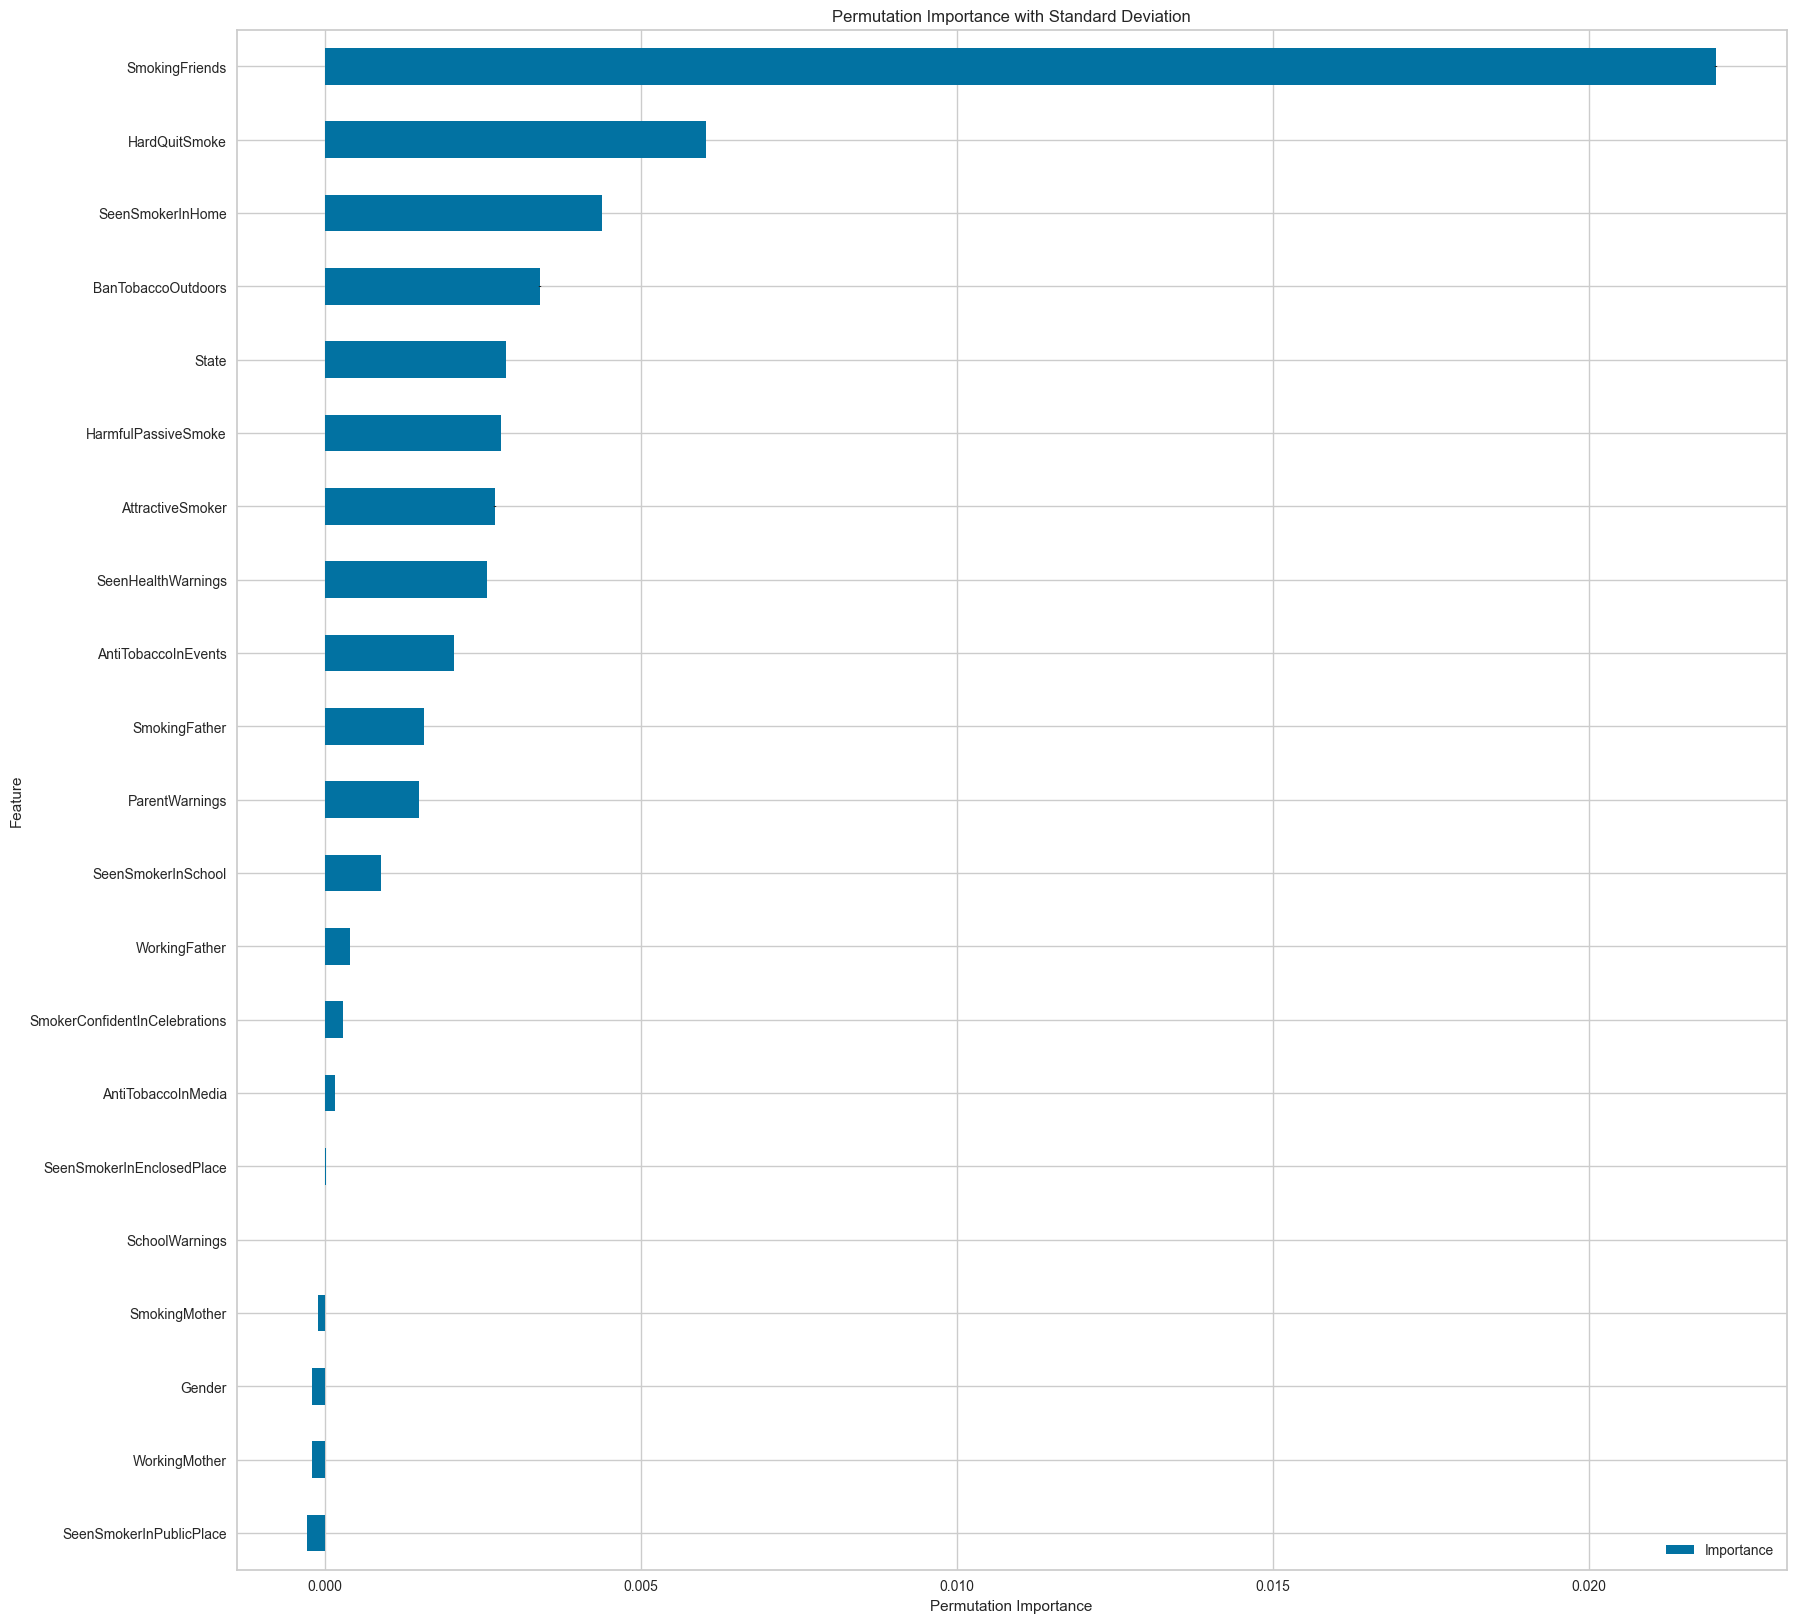

In [ ]:
from sklearn.inspection import permutation_importance

# trasformed data
X_test = pc.get_config("X_test_transformed")
y_test = pc.get_config("y_test_transformed")
X = pc.get_config("X_transformed")


result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)


feature_importance = pd.DataFrame({'Feature': X.columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
# feature_importance.head()

ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(20, 20), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')

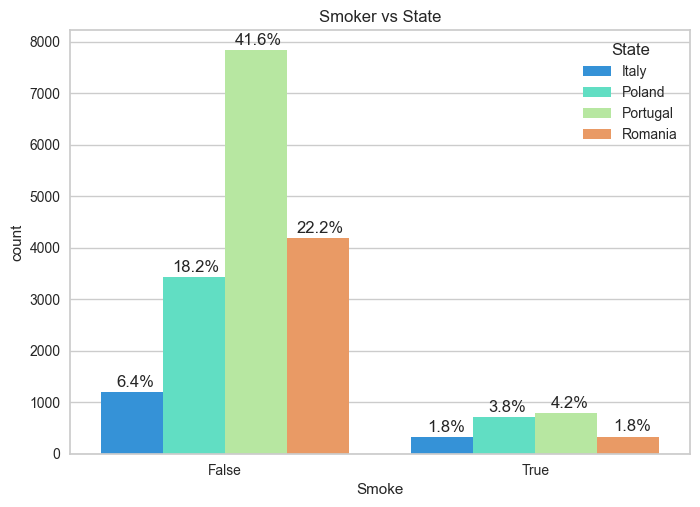

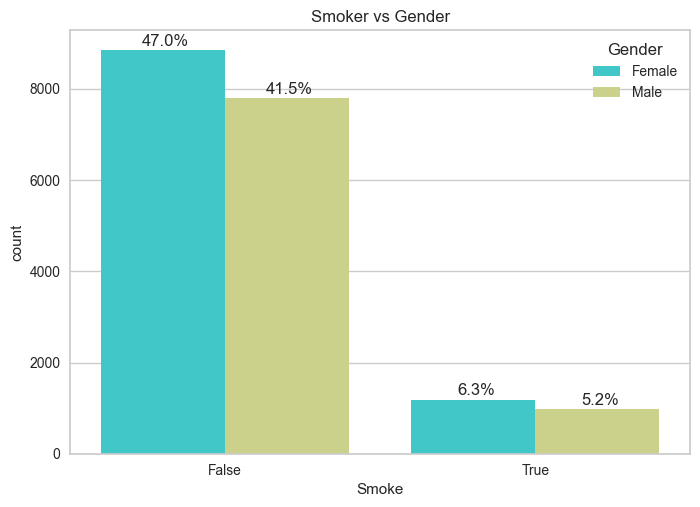

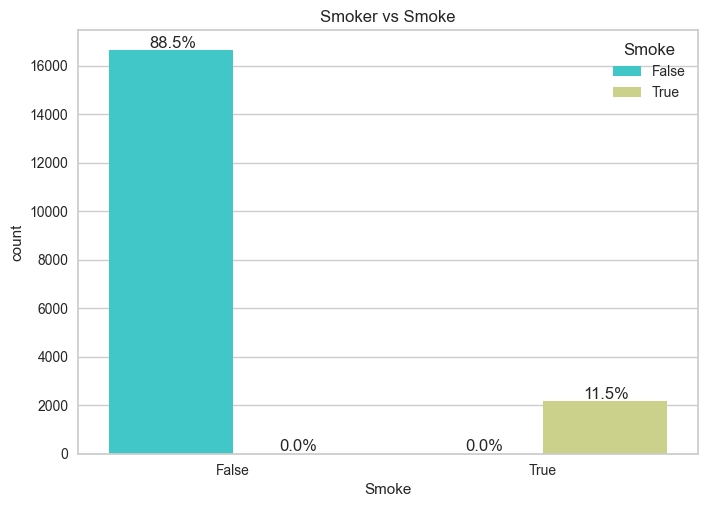

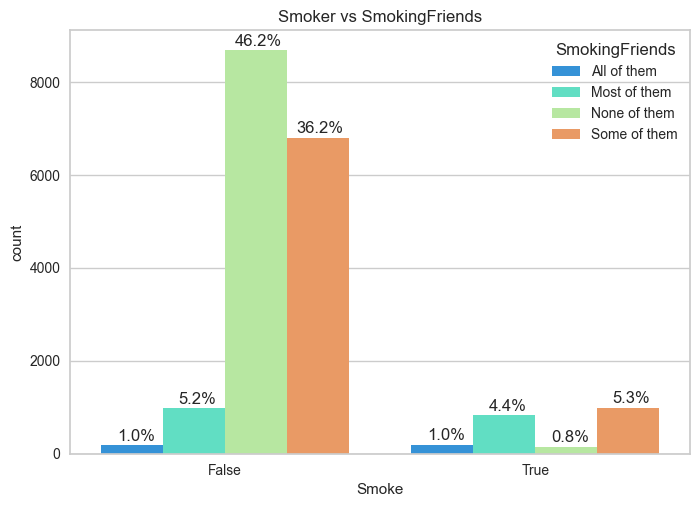

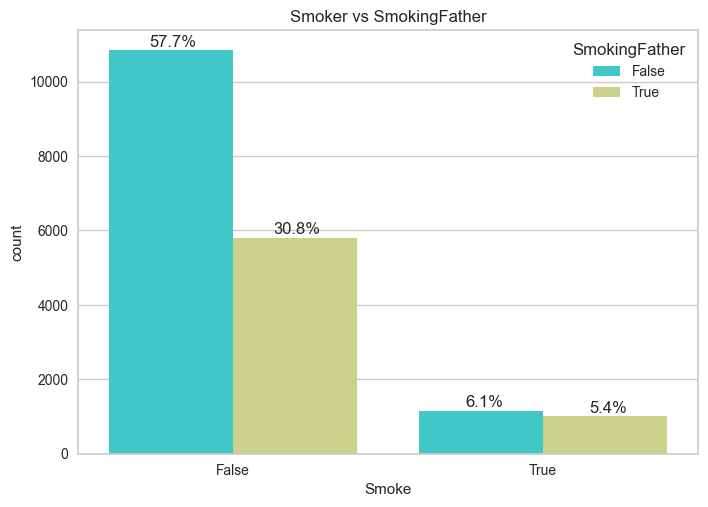

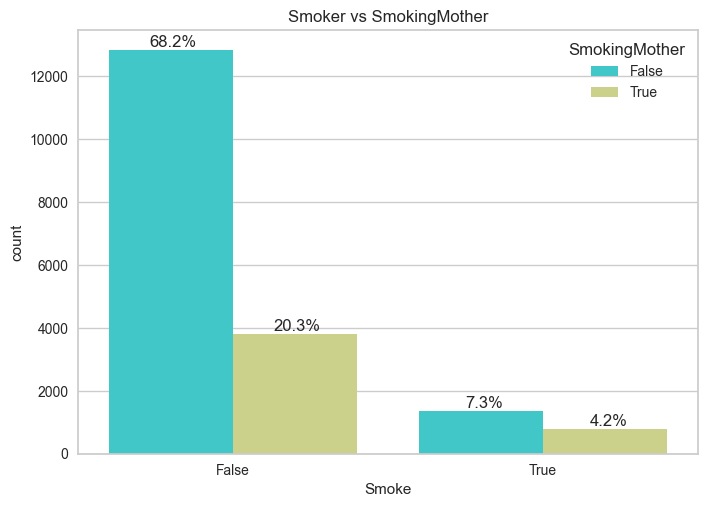

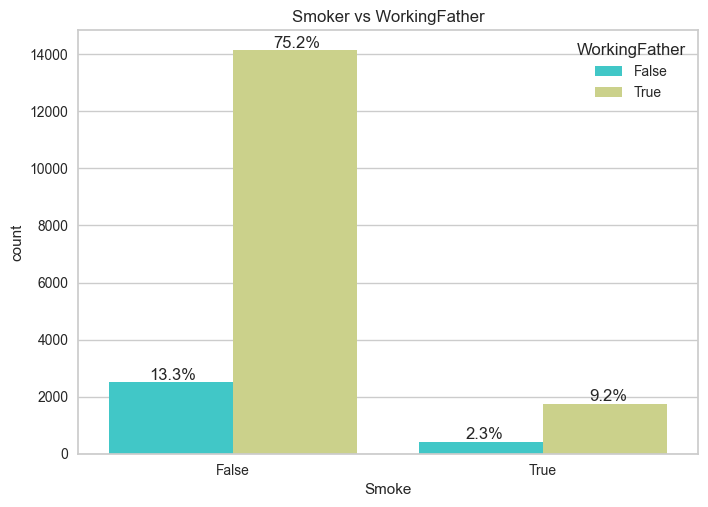

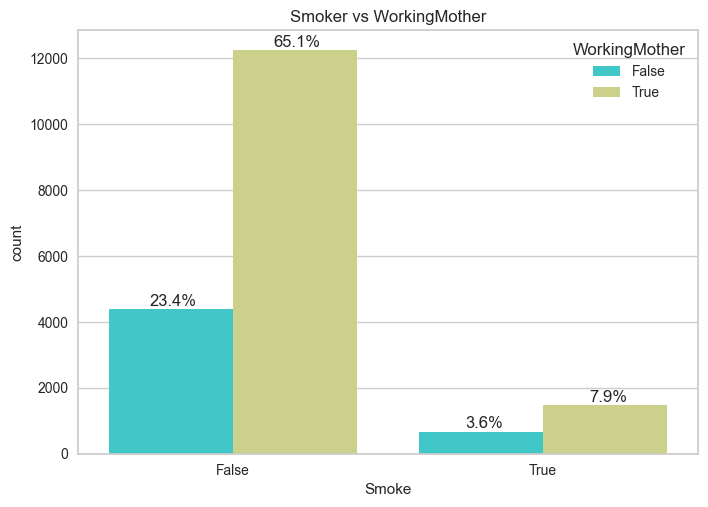

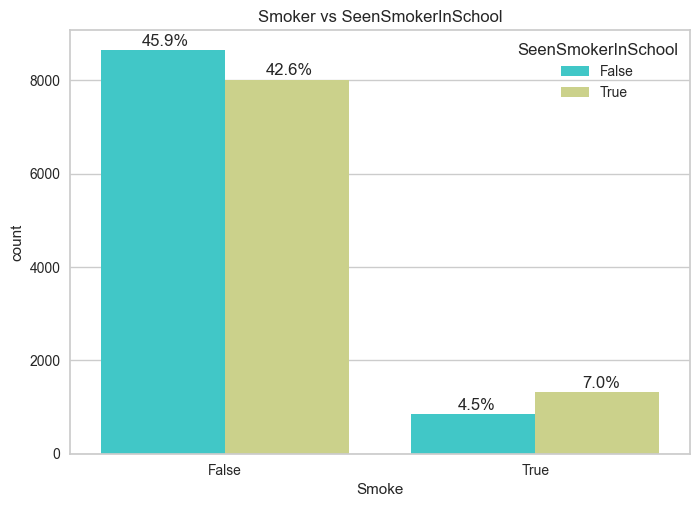

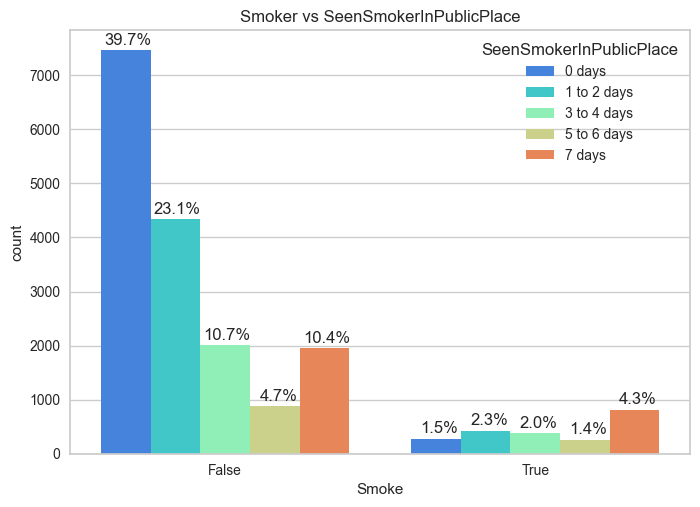

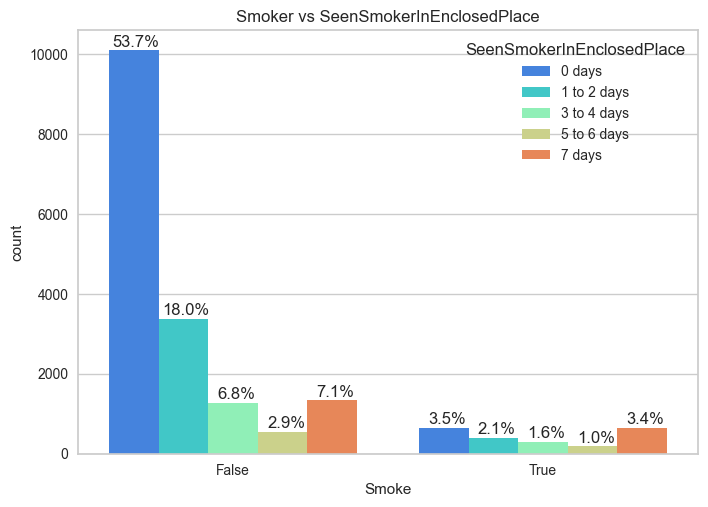

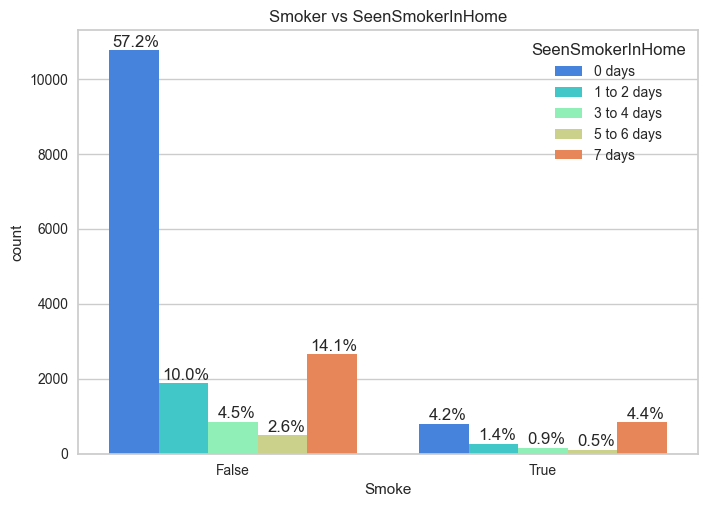

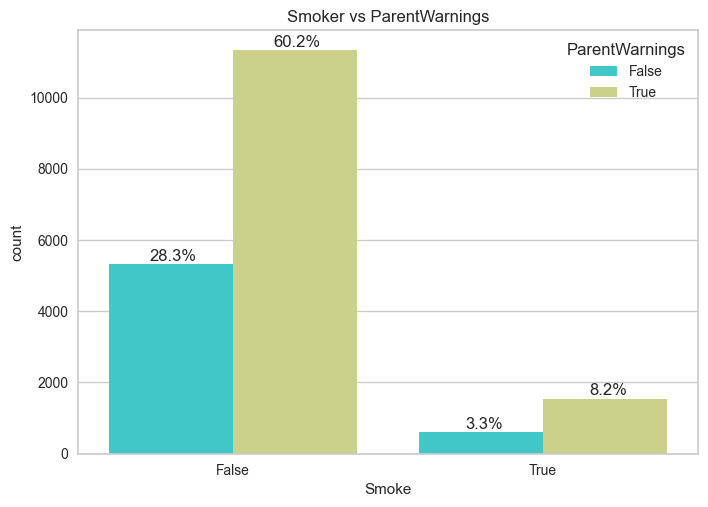

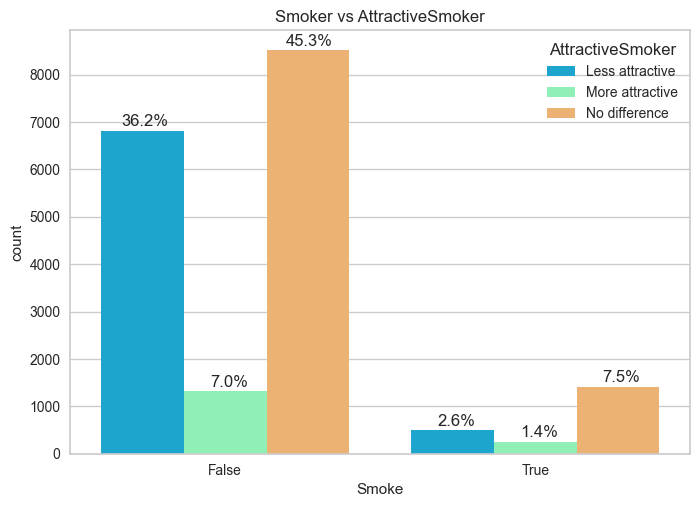

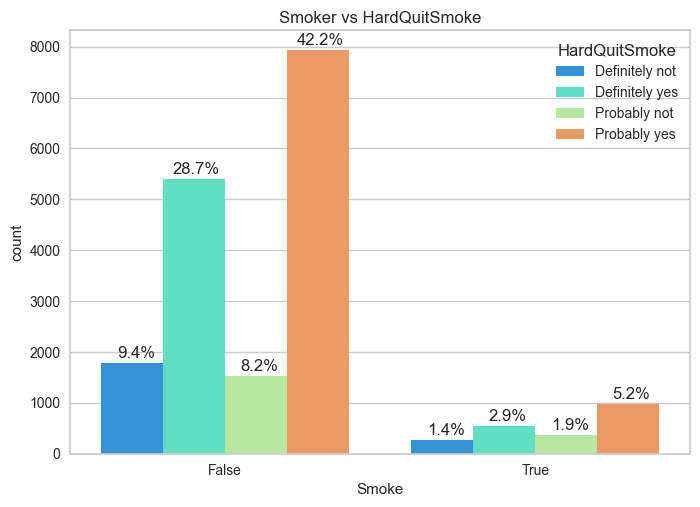

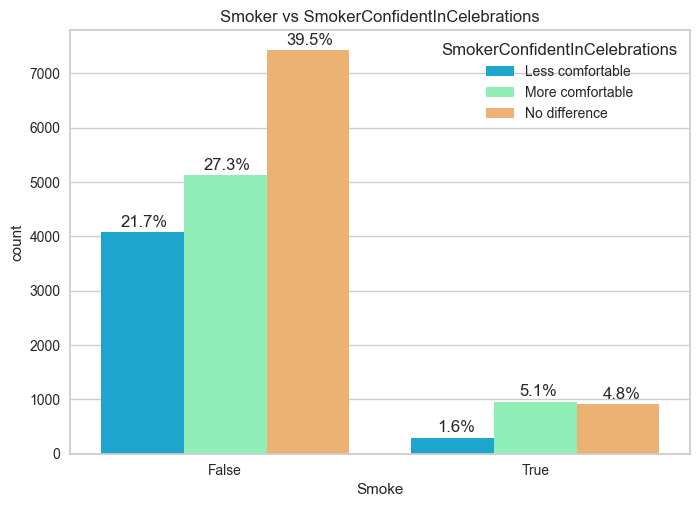

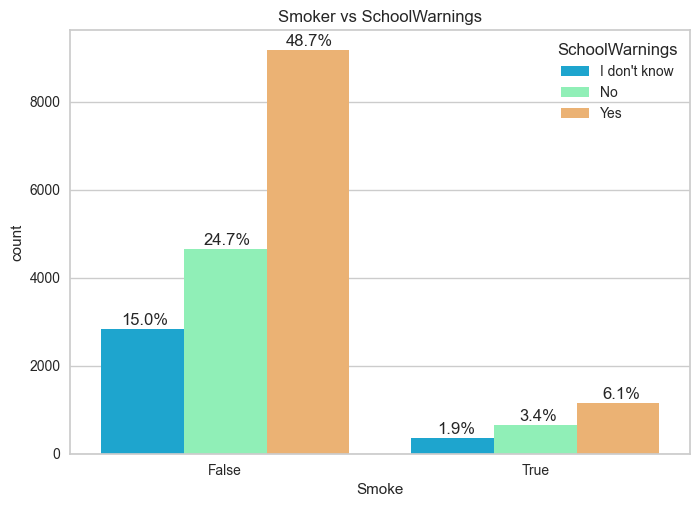

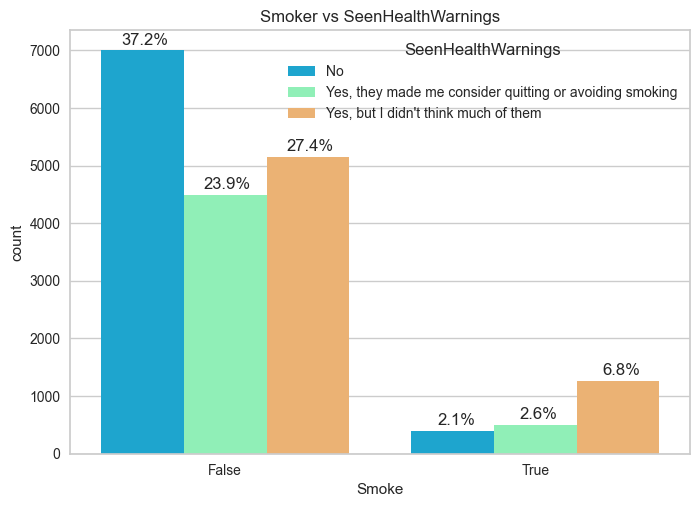

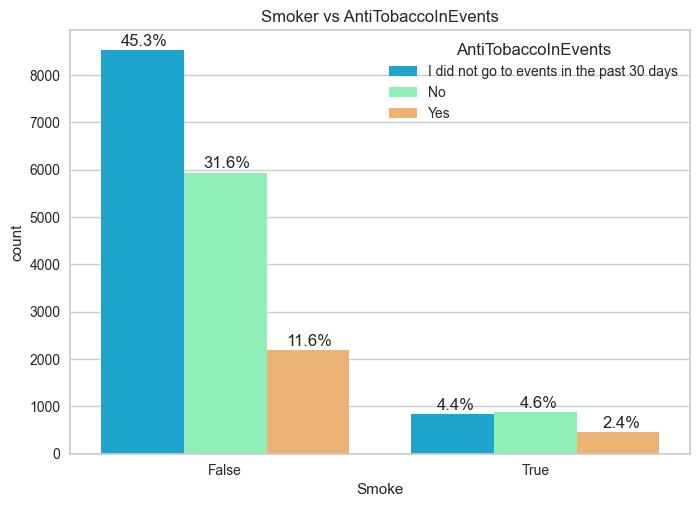

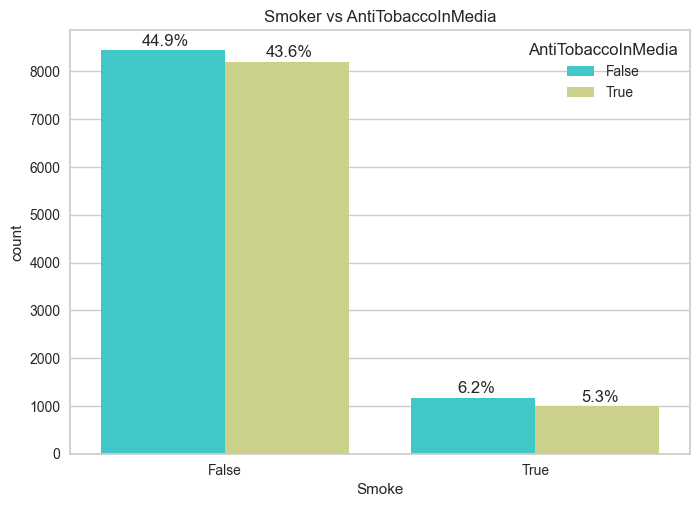

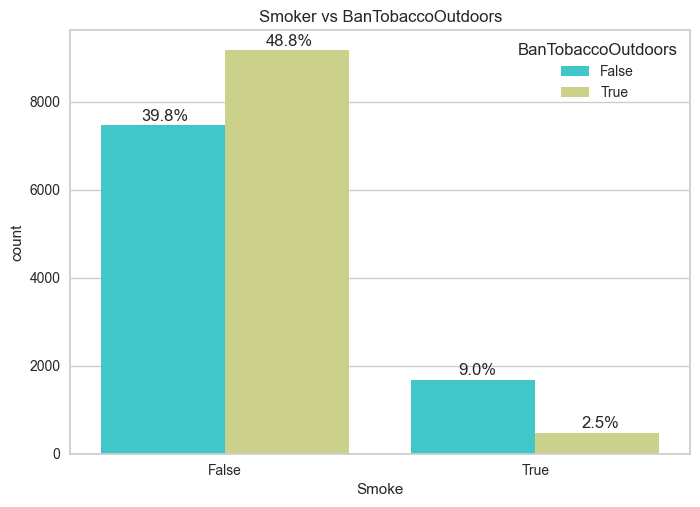

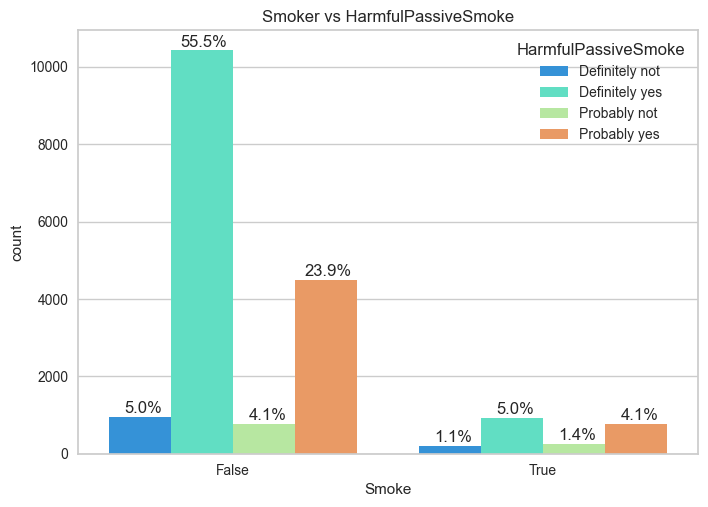

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

list_of_columns = ["State", "Gender", "Smoke", "SmokingFriends", 'SmokingFather', 'SmokingMother', 'WorkingFather', 'WorkingMother',
                       "SeenSmokerInSchool", "SeenSmokerInPublicPlace", "SeenSmokerInEnclosedPlace",
                       "SeenSmokerInHome", "ParentWarnings", "AttractiveSmoker", "HardQuitSmoke",
                       "SmokerConfidentInCelebrations", "SchoolWarnings", "SeenHealthWarnings",
                       "AntiTobaccoInEvents", "AntiTobaccoInMedia", "BanTobaccoOutdoors",
                       "HarmfulPassiveSmoke"
                    ]

def bar_perc(plot, dataframe, feature):
    total = len(feature) # length of the column
    total_smokers = len(dataframe[dataframe['Smoke'] == True]) # length of the smokers
    total_non_smokers = len(dataframe[dataframe['Smoke'] == False]) # length of the non-smokers
  
    for i, p in enumerate(plot.patches):
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
     
        x = p.get_x() + p.get_width() / 2 - (0.05 if (100 * p.get_height()/total) < 10 else 0.07) # width of the plot
        y = p.get_y() + p.get_height() + 100        # height of the plot
        plot.annotate(percentage, (x, y), size = 12) # annotate the percentage
        
merged_df2 = merged_df.copy()
merged_df2['SeenHealthWarnings'] = merged_df2['SeenHealthWarnings'].map(
    {"Yes, and they led me to think about quitting smoking or not starting smoking": "Yes, they made me consider quitting or avoiding smoking",
     "Yes, but I didn't think much of them": "Yes, but I didn't think much of them",
     "No": "No",})

for i, column in enumerate(list_of_columns):
    ax=sns.countplot(x='Smoke', hue=column, data=merged_df2, palette='rainbow', dodge=True)
    bar_perc(ax,merged_df, merged_df2[column])
    ax.set(title=f"Smoker vs {column}");
    
    
    
    
    # ax = sns.histplot(data=merged_df, x=column, hue='Smoke', multiple="dodge",
    #                 stat='percent', shrink = 0.8, common_norm=False,bins=2)
    # ax.bar_label(ax.containers[0], fmt='%.2f%%')
    # ax.bar_label(ax.containers[1], fmt='%.2f%%')
    # # print(list(ax.containers[1]))
    plt.savefig(f"../../data/processed/multivariate_analyisis/{column}_histogram.png")
    plt.show()
    
# # count smokers and non-smokers by AttractiveSmoker
# sns.countplot(x='AttractiveSmoker', hue='Smoke', data=merged_df)
# plt.show()
# percentage of smokers and non-smokers by AttractiveSmoker in percentage
# x,y = 'AttractiveSmoker', 'Smoke'

# (merged_df.groupby(x)[y]
# .value_counts(normalize=True)
# .mul(100)
# .rename('percent')
# .reset_index()
# .pipe((sns.catplot,'data'), x=x, y='percent',hue=y, kind='bar'))


In [ ]:
# model = ExtraTreesClassifier(model)

pd.DataFrame({'Feature': pc.get_config('X_train').columns, 'Value': abs(
    model.feature_importances_)}).sort_values(by='Value', ascending=False)

In [ ]:
pc.check_fairness(model, sensitive_features=['Age', "Gender"])